# Resume & Job offers - text analysis
## Dawid Szyszko-Celiński (443709)

### Aim of the project

The aim of the project is to perform text analysis of Resumes and job offers at the same time. In further parts I would like to simulate a few business cases considering recruitment process such as:

1) We have one place that gathers all Resumes but want to internally divide into groups so that specialists from each branch can look at Resumes without redirecting resumes and they can be assessed directly by department manager / HR specialist

2) We have a jobs offer portal and we want to automatically categorize job offers based if they are IT / Non-IT to make filtering more appealing and help users to find offers easier

3) We are jobs offer portal and we gather both CVs and Resumes. We want to provide a service that will somehow connect chosen offer/resume so that both sides can contact potential employer/employee from portal reccomendation

Resumes data comes from - https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset

Job offers data comes from - https://www.kaggle.com/datasets/madhab/jobposts/code

#### First let us load all necessary packages to perform analyses

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier

import transformers
from transformers import BertTokenizer, BertModel
import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

%matplotlib inline

np.random.seed(7)

C:\Users\justy\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Let us load Resume data first and perform some preprocessing

In [2]:
df_resume = pd.read_csv('.../UpdatedResumeDataSet.csv', encoding='utf-8')

In [3]:
print(df_resume.columns)

## Add a new variable with length of resuem before cleaning

df_resume["Resume_str"] = df_resume["Resume"].copy()
df_resume['length']=df_resume['Resume_str'].apply(len)

Index(['Category', 'Resume'], dtype='object')


In [4]:
## Let us see how the data looks like
df_resume.head()

,Category,Resume,Resume_str,length
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills * Programming Languages: Python (pandas...,4786
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details \r\nMay 2013 to May 2017 B.E...,1268
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","Areas of Interest Deep Learning, Control Syste...",1871
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,6995
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","Education Details \r\n MCA YMCAUST, Faridab...",452


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'Data Science'),
  Text(1, 0, 'HR'),
  Text(2, 0, 'Advocate'),
  Text(3, 0, 'Arts'),
  Text(4, 0, 'Web Designing'),
  Text(5, 0, 'Mechanical Engineer'),
  Text(6, 0, 'Sales'),
  Text(7, 0, 'Health and fitness'),
  Text(8, 0, 'Civil Engineer'),
  Text(9, 0, 'Java Developer'),
  Text(10, 0, 'Business Analyst'),
  Text(11, 0, 'SAP Developer'),
  Text(12, 0, 'Automation Testing'),
  Text(13, 0, 'Electrical Engineering'),
  Text(14, 0, 'Operations Manager'),
  Text(15, 0, 'Python Developer'),
  Text(16, 0, 'DevOps Engineer'),
  Text(17, 0, 'Network Security Engineer'),
  Text(18, 0, 'PMO'),
  Text(19, 0, 'Database'),
  Text(20, 0, 'Hadoop'),
  Text(21, 0, 'ETL Developer'),
  Text(22, 0, 'DotNet Developer'),
  Text(23, 0, 'Blockchain'),
  Text(24, 0, 'Testing')])

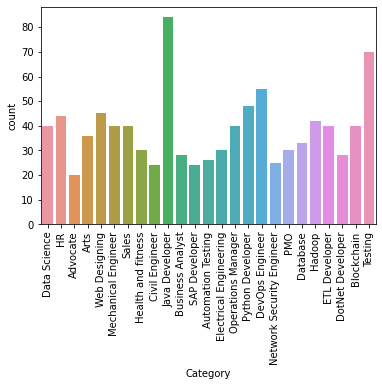

In [5]:
## Now let`s check the unique values of Categoreis and their frequencies

sns.countplot(x='Category', data=df_resume)
plt.xticks(rotation=90)

Lets see the distribution of lengths of resumes and lenghts per resume category

Text(0.5, 0, 'Length of Resumes')

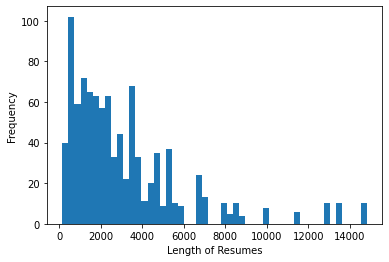

In [6]:
df_resume['length'].plot(bins=50,kind='hist')
plt.xlabel('Length of Resumes')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

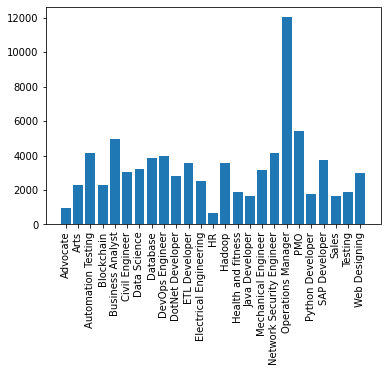

In [7]:
df_mean = df_resume.groupby("Category")["length"].mean()
plt.bar(df_mean.index, df_mean.values)
plt.xticks(rotation=90)

Now let us check the text

In [8]:
## And example of resume
df_resume['Resume_str'][1]

'Education Details \r\nMay 2013 to May 2017 B.E   UIT-RGPV\r\nData Scientist \r\n\r\nData Scientist - Matelabs\r\nSkill Details \r\nPython- Exprience - Less than 1 year months\r\nStatsmodels- Exprience - 12 months\r\nAWS- Exprience - Less than 1 year months\r\nMachine learning- Exprience - Less than 1 year months\r\nSklearn- Exprience - Less than 1 year months\r\nScipy- Exprience - Less than 1 year months\r\nKeras- Exprience - Less than 1 year monthsCompany Details \r\ncompany - Matelabs\r\ndescription - ML Platform for business professionals, dummies and enthusiasts.\r\n60/A Koramangala 5th block,\r\nAchievements/Tasks behind sukh sagar, Bengaluru,\r\nIndia                               Developed and deployed auto preprocessing steps of machine learning mainly missing value\r\ntreatment, outlier detection, encoding, scaling, feature selection and dimensionality reduction.\r\nDeployed automated classification and regression model.\r\nlinkedin.com/in/aditya-rathore-\r\nb4600b146        

As we can see the resume text is very messy, containing a lot of special signs. We shall clear the data before performing any analyses. It would be good to keep numbers like years of experience but for this project we will focus mostly on text. Future updates of the project may adress this issue.

#### Cleaning the data

In [9]:
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub("[\!?/:;''()``’“-”—#_-]", ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub(',', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub(r'[0-9]+', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('%', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub(':', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('&', 'and', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('"', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('\'', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('\|', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('\+', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('\$', 'dollar', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('\n', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('\xa0', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('\*', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('－', '', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('·', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('\.', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: re.sub('\s+', ' ', x))
df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: x.lower())

def remove_non_ascii(text):
    return text.encode('ascii', 'ignore').decode('ascii')

df_resume['Resume_str'] = df_resume['Resume_str'].map(lambda x: remove_non_ascii(x))

Now let us check the changes after cleaning the data

In [10]:
df_resume['Resume_str'][1]

'education details may to may b e uit rgpv data scientist data scientist matelabs skill details python exprience less than year months statsmodels exprience months aws exprience less than year months machine learning exprience less than year months sklearn exprience less than year months scipy exprience less than year months keras exprience less than year monthscompany details company matelabs description ml platform for business professionals dummies and enthusiasts a koramangala th block achievements tasks behind sukh sagar bengaluru india developed and deployed auto preprocessing steps of machine learning mainly missing value treatment outlier detection encoding scaling feature selection and dimensionality reduction deployed automated classification and regression model linkedin com in aditya rathore b b reasearch and deployed the time series forecasting model arima sarimax holt winter and prophet worked on meta feature extracting problem github com rathorology implemented a state o

### Now let us delete stopwords and stem the data

In [11]:
resume_text = df_resume['Resume_str'].apply(lambda x: x.split())
ps = PorterStemmer()

for i in range(0,len(resume_text)):
    words = []
    for word in resume_text[i]:
        words.append(ps.stem(word))
    resume_text[i] = words


In [12]:
## We can see that the text is stemmed right now

resume_text[0]

['skill',
 'program',
 'languag',
 'python',
 'panda',
 'numpi',
 'scipi',
 'scikit',
 'learn',
 'matplotlib',
 'sql',
 'java',
 'javascript',
 'jqueri',
 'machin',
 'learn',
 'regress',
 'svm',
 'nave',
 'bay',
 'knn',
 'random',
 'forest',
 'decis',
 'tree',
 'boost',
 'techniqu',
 'cluster',
 'analysi',
 'word',
 'embed',
 'sentiment',
 'analysi',
 'natur',
 'languag',
 'process',
 'dimension',
 'reduct',
 'topic',
 'model',
 'lda',
 'nmf',
 'pca',
 'and',
 'neural',
 'net',
 'databas',
 'visual',
 'mysql',
 'sqlserver',
 'cassandra',
 'hbase',
 'elasticsearch',
 'd',
 'js',
 'dc',
 'js',
 'plotli',
 'kibana',
 'matplotlib',
 'ggplot',
 'tableau',
 'other',
 'regular',
 'express',
 'html',
 'css',
 'angular',
 'logstash',
 'kafka',
 'python',
 'flask',
 'git',
 'docker',
 'comput',
 'vision',
 'open',
 'cv',
 'and',
 'understand',
 'of',
 'deep',
 'learn',
 'educ',
 'detail',
 'data',
 'scienc',
 'assur',
 'associ',
 'data',
 'scienc',
 'assur',
 'associ',
 'ernst',
 'and',
 'young'

In [13]:
stop_words = nltk.corpus.stopwords.words('english')

stop_words = pd.Series(stop_words).map(lambda x: re.sub('\n', '', x))
stop_words = stop_words.map(lambda x: re.sub("[,\!?/:;''()``]_", '', x))
stop_words = stop_words.map(lambda x: re.sub(r"([.]+)", '', x))

In [14]:
## stemming stopwords
for i in range(0,len(stop_words)):
    stop_words[i] = ps.stem(stop_words[i])

stop_words

## making stopwords back a list
stop_words = list(stop_words)

## removing stopwords
for i in range(0,len(resume_text)):
    resume_text[i] = [word for word in resume_text[i] if not word in list(stop_words)]

In [15]:
# We can see that the text is stemmed and stopwords are removed

resume_text[0]

['skill',
 'program',
 'languag',
 'python',
 'panda',
 'numpi',
 'scipi',
 'scikit',
 'learn',
 'matplotlib',
 'sql',
 'java',
 'javascript',
 'jqueri',
 'machin',
 'learn',
 'regress',
 'svm',
 'nave',
 'bay',
 'knn',
 'random',
 'forest',
 'decis',
 'tree',
 'boost',
 'techniqu',
 'cluster',
 'analysi',
 'word',
 'embed',
 'sentiment',
 'analysi',
 'natur',
 'languag',
 'process',
 'dimension',
 'reduct',
 'topic',
 'model',
 'lda',
 'nmf',
 'pca',
 'neural',
 'net',
 'databas',
 'visual',
 'mysql',
 'sqlserver',
 'cassandra',
 'hbase',
 'elasticsearch',
 'js',
 'dc',
 'js',
 'plotli',
 'kibana',
 'matplotlib',
 'ggplot',
 'tableau',
 'regular',
 'express',
 'html',
 'css',
 'angular',
 'logstash',
 'kafka',
 'python',
 'flask',
 'git',
 'docker',
 'comput',
 'vision',
 'open',
 'cv',
 'understand',
 'deep',
 'learn',
 'educ',
 'detail',
 'data',
 'scienc',
 'assur',
 'associ',
 'data',
 'scienc',
 'assur',
 'associ',
 'ernst',
 'young',
 'llp',
 'skill',
 'detail',
 'javascript',
 

### Now let us load the job offers dataset

In [16]:
df_job = pd.read_csv('.../data job posts.csv', encoding='utf-8')
print(df_job.head())

                                             jobpost          date  \
0  AMERIA Investment Consulting Company\r\nJOB TI...   Jan 5, 2004   
1  International Research & Exchanges Board (IREX...   Jan 7, 2004   
2  Caucasus Environmental NGO Network (CENN)\r\nJ...   Jan 7, 2004   
3  Manoff Group\r\nJOB TITLE:  BCC Specialist\r\n...   Jan 7, 2004   
4  Yerevan Brandy Company\r\nJOB TITLE:  Software...  Jan 10, 2004   

                                               Title  \
0                            Chief Financial Officer   
1  Full-time Community Connections Intern (paid i...   
2                                Country Coordinator   
3                                     BCC Specialist   
4                                 Software Developer   

                                           Company AnnouncementCode Term  \
0             AMERIA Investment Consulting Company              NaN  NaN   
1  International Research & Exchanges Board (IREX)              NaN  NaN   
2        Cauca

In [17]:
print(df_job.columns)
print(df_job.shape)

Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT'],
      dtype='object')
(19001, 24)


#### Delete columns that have a lot of Na`s

In [18]:
df_job = df_job.drop("date", axis=1)
df_job['AnnouncementCode']
df_job = df_job.drop("AnnouncementCode", axis=1)
df_job['Term']
df_job = df_job.drop("Term", axis=1)
df_job['Eligibility']
df_job = df_job.drop("Eligibility", axis=1)
df_job['Audience']
df_job = df_job.drop("Audience", axis=1)
df_job['Duration']
df_job = df_job.drop("Duration", axis=1)
df_job = df_job.drop("StartDate", axis=1)
df_job = df_job.drop("OpeningDate", axis=1)
df_job = df_job.drop("Deadline", axis=1)
df_job['Notes']
df_job = df_job.drop("Notes", axis=1)
df_job['ApplicationP']
df_job = df_job.drop("ApplicationP", axis=1)
df_job['AboutC']
df_job = df_job.drop("AboutC", axis=1)
df_job['Attach']
df_job = df_job.drop("Attach", axis=1)
df_job['Location']
df_job = df_job.drop("Location", axis=1)
df_job = df_job.drop("Year", axis=1)
df_job = df_job.drop("Month", axis=1)
df_job['Salary']
df_job = df_job.drop("Salary", axis=1)

In [19]:
## Add variable - length of the text

df_job['length']=df_job['jobpost'].apply(len)
df_job.head()

print(df_job.columns)

Index(['jobpost', 'Title', 'Company', 'JobDescription', 'JobRequirment',
       'RequiredQual', 'IT', 'length'],
      dtype='object')


Take a look at text column example. We can see that it is not cleaned at all. We will need to perfom some cleaning of jobpost text

In [20]:
df_job['jobpost'][1]

"International Research & Exchanges Board (IREX)\r\nTITLE:   Full-time Community Connections Intern (paid internship)\r\nDURATION:  3 months\r\nLOCATION:  IREX Armenia Main Office; Yerevan, Armenia \r\nDESCRIPTION:   IREX currently seeks to fill the position of a paid\r\nIntern for the Community Connections (CC) Program. The position is based\r\nin the Yerevan office however applicants must be willing to travel\r\nthroughout Armenia as necessary.  This position reports directly to the\r\nCC Program Manager.\r\nRESPONSIBILITIES:  \r\n- Presenting the CC program to interested parties; \r\n- Assisting in planning and scheduling of programmatic meetings and\r\nevents (this includes coordinating logistics for CC staff, visitors and\r\nparticipants);\r\n- Assisting the Program Staff;\r\n- Translation/Interpretation from Armenian to English and vice versa;\r\n- Helping create, maintain and update the CC filing system and\r\ndatabases;\r\n- Completing general administrative tasks for the CC pr

#### Data cleaning

In [21]:
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub("[\!?/:;''()``’“-”—#_-]", ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub(',', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub(r'[0-9]+', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('%', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub(':', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('&', 'and', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('"', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('\'', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('\|', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('\+', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('\$', 'dollar', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('\n', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('\xa0', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('－', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('@', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('-', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('·', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('\.', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: re.sub('\s+', ' ', x))
df_job['jobpost'] = df_job['jobpost'].map(lambda x: x.lower())

df_job['jobpost'] = df_job['jobpost'].map(lambda x: remove_non_ascii(x))

Let`s see how the data looks like after cleaning

In [22]:
df_job['jobpost'][1]

'international research and exchanges board irex title full time community connections intern paid internship duration months location irex armenia main office yerevan armenia description irex currently seeks to fill the position of a paid intern for the community connections cc program the position is based in the yerevan office however applicants must be willing to travel throughout armenia as necessary this position reports directly to the cc program manager responsibilities presenting the cc program to interested parties assisting in planning and scheduling of programmatic meetings and events this includes coordinating logistics for cc staff visitors and participants assisting the program staff translation interpretation from armenian to english and vice versa helping create maintain and update the cc filing system and databases completing general administrative tasks for the cc program within the office other duties as assigned needed required qualifications bachelor s degree mast

#### Now let us stem words and delete stopwords

In [23]:
job_text = df_job['jobpost'].apply(lambda x: x.split())

ps = PorterStemmer()

for i in range(0,len(job_text)):
    words = []
    for word in job_text[i]:
        words.append(ps.stem(word))
    job_text[i] = words

In [24]:
job_text[0]

['ameria',
 'invest',
 'consult',
 'compani',
 'job',
 'titl',
 'chief',
 'financi',
 'offic',
 'posit',
 'locat',
 'yerevan',
 'armenia',
 'job',
 'descript',
 'ameria',
 'invest',
 'consult',
 'compani',
 'is',
 'seek',
 'a',
 'chief',
 'financi',
 'offic',
 'thi',
 'posit',
 'manag',
 'the',
 'compani',
 's',
 'fiscal',
 'and',
 'administr',
 'function',
 'provid',
 'highli',
 'respons',
 'and',
 'technic',
 'complex',
 'staff',
 'assist',
 'to',
 'the',
 'execut',
 'director',
 'the',
 'work',
 'perform',
 'requir',
 'a',
 'high',
 'level',
 'of',
 'technic',
 'profici',
 'in',
 'financi',
 'manag',
 'and',
 'invest',
 'manag',
 'as',
 'well',
 'as',
 'manag',
 'supervisori',
 'and',
 'administr',
 'skill',
 'job',
 'respons',
 'supervis',
 'financi',
 'manag',
 'and',
 'administr',
 'staff',
 'includ',
 'assign',
 'respons',
 'review',
 'employe',
 'work',
 'process',
 'and',
 'product',
 'counsel',
 'employe',
 'give',
 'perform',
 'evalu',
 'and',
 'recommend',
 'disciplinari',


In [25]:
stop_words = nltk.corpus.stopwords.words('english')

stop_words = pd.Series(stop_words).map(lambda x: re.sub('\n', '', x))
stop_words = stop_words.map(lambda x: re.sub("[,\!?/:;''()``]_", '', x))
stop_words = stop_words.map(lambda x: re.sub(r"([.]+)", '', x))

## stemming stopwords
for i in range(0,len(stop_words)):
    stop_words[i] = ps.stem(stop_words[i])

stop_words

## making stopwords back a list
stop_words = list(stop_words)

## removing stopwords
for i in range(0,len(job_text)):
    job_text[i] = [word for word in job_text[i] if not word in list(stop_words)]

In [26]:
job_text[0]

['ameria',
 'invest',
 'consult',
 'compani',
 'job',
 'titl',
 'chief',
 'financi',
 'offic',
 'posit',
 'locat',
 'yerevan',
 'armenia',
 'job',
 'descript',
 'ameria',
 'invest',
 'consult',
 'compani',
 'seek',
 'chief',
 'financi',
 'offic',
 'posit',
 'manag',
 'compani',
 'fiscal',
 'administr',
 'function',
 'provid',
 'highli',
 'respons',
 'technic',
 'complex',
 'staff',
 'assist',
 'execut',
 'director',
 'work',
 'perform',
 'requir',
 'high',
 'level',
 'technic',
 'profici',
 'financi',
 'manag',
 'invest',
 'manag',
 'well',
 'manag',
 'supervisori',
 'administr',
 'skill',
 'job',
 'respons',
 'supervis',
 'financi',
 'manag',
 'administr',
 'staff',
 'includ',
 'assign',
 'respons',
 'review',
 'employe',
 'work',
 'process',
 'product',
 'counsel',
 'employe',
 'give',
 'perform',
 'evalu',
 'recommend',
 'disciplinari',
 'action',
 'serv',
 'member',
 'manag',
 'team',
 'particip',
 'strateg',
 'oper',
 'plan',
 'compani',
 'direct',
 'overse',
 'compani',
 'financi

Let`s see the distribution of lengths of job offers

Text(0.5, 0, 'Length of Resume')

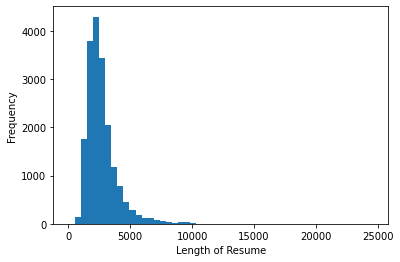

In [27]:
df_job['length'].plot(bins=50,kind='hist')
plt.xlabel('Length of Resume')

Let`s see the distribution of IT / Non-IT jobs

<AxesSubplot:xlabel='count', ylabel='IT'>

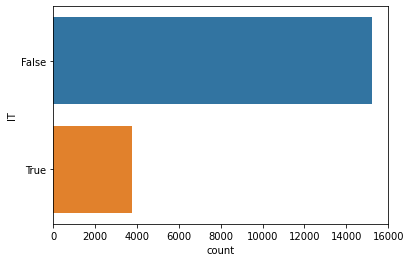

In [28]:
sns.countplot(y='IT', data=df_job)

(array([-0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

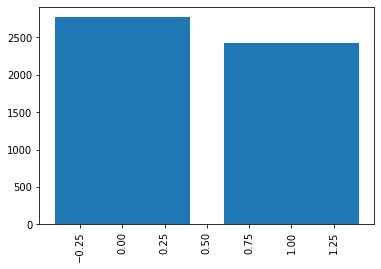

In [29]:
df_mean = df_job.groupby("IT")["length"].mean()
plt.bar(df_mean.index, df_mean.values)
plt.xticks(rotation=90)

## First business case
We have a big comapny that mainly hires IT staff but also many other specialist.
We have one place that gathers all Resumes but want to internally divide into groups so that specialists from each branch can look at Resumes without redirecting resumes and assess directly by department manager / HR specialist

In [30]:
def listToString(s):  
    str1 = ""   
    for ele in s:  
        str1 += ele+" "    
    return str1

df_resume["resume_text_preprocessed"] = ""

for i in range(0,len(resume_text)):
    df_resume["resume_text_preprocessed"][i] = listToString(resume_text[i])

data = df_resume.copy()

C:\Users\justy\AppData\Local\Temp/ipykernel_27784/2886617952.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resume["resume_text_preprocessed"][i] = listToString(resume_text[i])


We have 962 resumes that we need to divide into IT / Non-IT groups

In [31]:
data.describe()

,length
count,962.000000
mean,3160.364865
std,2886.528521
min,142.000000
25%,1217.250000
50%,2355.000000
75%,4073.750000
max,14816.000000


Let us split the data into training and testing and then create model that can assess if the resume is IT or non-IT in the future

In [32]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.3)
for train_index, test_index in split.split(data,
                                           data["Category"]): 
    strat_train = data.reindex(train_index)
    strat_test = data.reindex(test_index)

Check balance of groups. It is not fully balanced, however let us leave it as it is.

In [33]:
strat_train["Category"].value_counts()/len(strat_train)

Java Developer               0.087667
Testing                      0.072808
DevOps Engineer              0.056464
Python Developer             0.050520
HR                           0.046062
Web Designing                0.046062
Hadoop                       0.043091
Operations Manager           0.041605
Blockchain                   0.041605
ETL Developer                0.041605
Sales                        0.041605
Data Science                 0.041605
Mechanical Engineer          0.041605
Arts                         0.037147
Database                     0.034175
PMO                          0.031204
Electrical Engineering       0.031204
Health and fitness           0.031204
Business Analyst             0.029718
DotNet Developer             0.029718
Automation Testing           0.026746
SAP Developer                0.025260
Civil Engineer               0.025260
Network Security Engineer    0.025260
Advocate                     0.020802
Name: Category, dtype: float64

In [34]:
# prepare data for the model
X_train = strat_train["resume_text_preprocessed"]
y_train = strat_train["Category"]
X_test = strat_test["resume_text_preprocessed"]
y_test = strat_test["Category"]
print(len(X_train), len(X_test))

673 289


In [35]:
count_vect = CountVectorizer(max_df = 0.85, min_df = 0.1)
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(673, 304)

In [36]:
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(673, 304)

#### LinearSVC

In [37]:
clf_linearSVC_pipe = Pipeline([("vect", CountVectorizer()), 
                               ("tfidf", TfidfTransformer()),
                               ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_linearSVC', LinearSVC())])

In [38]:
predictedLinearSVC = clf_linearSVC_pipe.predict(X_test)
np.mean(predictedLinearSVC == y_test)

0.9826989619377162

In [39]:
print(classification_report(y_test,predictedLinearSVC))
print(confusion_matrix(y_test,predictedLinearSVC))

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         6
                     Arts       1.00      1.00      1.00        11
       Automation Testing       1.00      0.75      0.86         8
               Blockchain       1.00      1.00      1.00        12
         Business Analyst       1.00      1.00      1.00         8
           Civil Engineer       1.00      1.00      1.00         7
             Data Science       1.00      1.00      1.00        12
                 Database       1.00      1.00      1.00        10
          DevOps Engineer       1.00      0.82      0.90        17
         DotNet Developer       0.89      1.00      0.94         8
            ETL Developer       1.00      1.00      1.00        12
   Electrical Engineering       0.82      1.00      0.90         9
                       HR       1.00      1.00      1.00        13
                   Hadoop       1.00      1.00      1.00     

Now let us test some new artificial data that I came up with. It just contains keywords, however it should be enough.

In [40]:
resume_1 = ["python", "java", "agile", "scrum", "english", "french", "slack", "jira", "confluence", "it", "excel", "vba", "microsoft"]

resume_2 = ["law", "school", "jury", "civil", "law", "application", "advocate", "office", "professional", "diploma", "claim", "conflict", "represent"]

resume_3 = ["cook", "food", "product", "chef", "restaurant", "coffe", "serve", "dish", "cook", "sushi", "food", "cousine"]

resume_4 = ["stock", "finance", "accounting", "bookings", "clients", "shares", "excel", "transactions", "accounting"]

strings = [resume_1, resume_2, resume_3, resume_4]

for i in range(0,len(strings)):
    words = []
    for word in strings[i]:
        words.append(ps.stem(word))
    strings[i] = words

for i in range(0,len(strings)):
    strings[i] = listToString(strings[i])

test_resumes = pd.DataFrame({'resume': strings})
test_results = clf_linearSVC_pipe.predict(test_resumes['resume'])

for i, test_results in enumerate(test_results):
    print(f"Prediction for resume {i + 1}: {test_results}")

Prediction for resume 1: Python Developer
Prediction for resume 2: Advocate
Prediction for resume 3: Health and fitness
Prediction for resume 4: HR


Now let us try some other tools such as logistic regression, K-nearest neighbours and Random forrest. Before such analysis we need to convert data to numeric

In [41]:
## Prepare data

Text= df_resume['resume_text_preprocessed'].values
Target= df_resume['Category'].values

word_vectorizer = TfidfVectorizer(sublinear_tf=True)
word_vectorizer.fit(Text)
WordFeatures= word_vectorizer.transform(Text)

X_train,X_test,y_train,y_test= train_test_split(WordFeatures, Target, random_state=42)

In [42]:
lr = LogisticRegression(multi_class='ovr')
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

#### Logistic Regression

Gives very good results with accuract arond 99%

In [43]:
lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

Check the accuracy of prediction

In [44]:
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

1.0
0.991701244813278


Check on the articicial data that I did for test

In [45]:
my_test = word_vectorizer.transform(test_resumes['resume'])
test_results = lr.predict(my_test)
print(test_results)

['Python Developer' 'Advocate' 'Health and fitness' 'HR']


#### KNN
Gives very good results but worse than Logistic regression

In [46]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [47]:
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.9875173370319001
0.966804979253112


In [48]:
my_test = word_vectorizer.transform(test_resumes['resume'])
test_results = knn.predict(my_test)
print(test_results)

['Python Developer' 'Advocate' 'Health and fitness' 'HR']


#### Random Forest

Gives results that can be compared with linearSVC

In [49]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [50]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

1.0
0.983402489626556


In [51]:
my_test = word_vectorizer.transform(test_resumes['resume'])
test_results = rf.predict(my_test)
print(test_results)

['Java Developer' 'Advocate' 'HR' 'HR']


## 2nd business case
We have a jobs offer portal and we want to automatically categorize job offers based if they are IT / Non-IT to make filtering more appealing and help users to find offers easier

In [52]:
df_job["job_text_preprocessed"] = ""

for i in range(0,len(job_text)):
    df_job["job_text_preprocessed"][i] = listToString(job_text[i])
    
data = df_job

C:\Users\justy\AppData\Local\Temp/ipykernel_27784/3228144375.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_job["job_text_preprocessed"][i] = listToString(job_text[i])


#### Split data for training and test sample 70/30

In [53]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.3)
for train_index, test_index in split.split(data,
                                           data["IT"]): 
    strat_train = data.reindex(train_index)
    strat_test = data.reindex(test_index)

Check if the data is balanced based on categories

In [54]:
strat_train["IT"].value_counts()/len(strat_train)

False    0.80218
True     0.19782
Name: IT, dtype: float64

In [55]:
# prepare data for the model
X_train = strat_train["job_text_preprocessed"]
y_train = strat_train["IT"]
X_test = strat_test["job_text_preprocessed"]
y_test = strat_test["IT"]
print(len(X_train), len(X_test))

13300 5701


In [56]:
count_vect = CountVectorizer(max_df = 0.85, min_df = 0.1)
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(13300, 291)

In [57]:
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(13300, 291)

In [58]:
clf_linearSVC_pipe = Pipeline([("vect", CountVectorizer()), 
                               ("tfidf", TfidfTransformer()),
                               ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_linearSVC', LinearSVC())])

In [59]:
predictedLinearSVC = clf_linearSVC_pipe.predict(X_test)
np.mean(predictedLinearSVC == y_test)

0.9496579547447817

In [60]:
print(classification_report(y_test,predictedLinearSVC))
print(confusion_matrix(y_test,predictedLinearSVC))

              precision    recall  f1-score   support

       False       0.96      0.98      0.97      4573
        True       0.90      0.84      0.87      1128

    accuracy                           0.95      5701
   macro avg       0.93      0.91      0.92      5701
weighted avg       0.95      0.95      0.95      5701

[[4462  111]
 [ 176  952]]


#### Result
We can see that the linearSVC algorith did very well as accuracy is around 95% for test data

In [61]:
offer_1 = ["python", "java", "agile", "scrum", "english", "french", "slack", "jira", "confluence", "it", "excel", "vba", "microsoft"]

offer_2 = ["law", "school", "jury", "civil", "law", "application", "advocate", "office", "professional", "diploma", "claim", "conflict", "represent"]

offer_3 = ["cook", "food", "product", "chef", "restaurant", "coffe", "serve", "dish", "cook", "sushi", "food", "cousine"]

offer_4 = ["stock", "finance", "accounting", "bookings", "clients", "shares", "excel", "transactions", "accounting"]

strings = [offer_1, offer_2, offer_3, offer_4]

for i in range(0,len(strings)):
    words = []
    for word in strings[i]:
        words.append(ps.stem(word))
    strings[i] = words

for i in range(0,len(strings)):
    strings[i] = listToString(strings[i])

test_offers = pd.DataFrame({'offer': strings})
test_results = clf_linearSVC_pipe.predict(test_offers['offer'])

for i, test_results in enumerate(test_results):
    print(f"Prediction for offer {i + 1}: {test_results}")

Prediction for offer 1: False
Prediction for offer 2: False
Prediction for offer 3: False
Prediction for offer 4: False


Unfortunately we were not able to detect that offer_1 should be assigned to IT offer based on the provided keywords. Maybe we should rather use longer text that can be analysed more precisely

In [62]:
## Prepare data

Text= df_job['job_text_preprocessed'].values
Target= df_job['IT'].values

word_vectorizer = TfidfVectorizer(sublinear_tf=True)
word_vectorizer.fit(Text)
WordFeatures= word_vectorizer.transform(Text)

X_train,X_test,y_train,y_test= train_test_split(WordFeatures, Target, random_state=42)

In [63]:
lr = LogisticRegression(multi_class='ovr')
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

#### Logistic Regression

It gives quite good results, however still we are not able to recognize offer_1 as an IT group

In [64]:
lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [65]:
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.9457543859649122
0.9343296148179331


In [66]:
my_test = word_vectorizer.transform(test_offers['offer'])
test_results = lr.predict(my_test)
print(test_results)

[False False False False]


#### KNN
Results very similar to Logistic Regression

In [67]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [68]:
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.9517192982456141
0.931172384761103


In [69]:
my_test = word_vectorizer.transform(test_offers['offer'])
test_results = knn.predict(my_test)
print(test_results)

[False False False False]


#### Random Forrest
It seems that it has a little beter results than previous algorithms but still is unable to predict our offer_1

In [70]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [71]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

1.0
0.9465375710376763


In [72]:
my_test = word_vectorizer.transform(test_offers['offer'])
test_results = rf.predict(my_test)
print(test_results)

[False False False False]


## 3rd business case
We are jobs offer portal and we gather both CVs and Resumes. We want to provide a service that will somehow connect chosen offer/resume so that both sides can contact potential employer/employee from portal reccomendation

First let us test if similarity measures works with one example. We will use n_similarity that is within gensim package. Iwith window = 5 we are able to set searching for word embedings that will have a poitive outcome as it will grab more context for each word (2 previous and 2 afterwards words).

What is more there will be used Jacard similarity that is calculated as words intersections within 2 documents divided by words union from 2 documents. It is not the perfet measure but still it can help us to find job offers and resumes that are similar based on the indication that is higher than average or median.

In [73]:
from gensim.models import Word2Vec

## vectorize the documents using the model's `wv` attribute

doc1 = df_resume['resume_text_preprocessed'][10]
doc2 = df_job['job_text_preprocessed'][3000]

print(doc1)
print(doc2)

sentences = [doc1.split(),doc2.split()]

model = Word2Vec(sentences, sg=1, window=5, min_count=1)

doc1_vec = model.wv[doc1.split()]
doc2_vec = model.wv[doc2.split()]

## compute the similarity using the `n_similarity()` method
similarity = model.wv.n_similarity(doc1_vec, doc2_vec)

print("Similarity score: ", similarity)

job_offer_words = doc1.split()
resume_words = doc2.split()

## convert to sets
job_offer_set = set(job_offer_words)
resume_set = set(resume_words)

## calculate intersection and union
intersection = job_offer_set.intersection(resume_set)
union = job_offer_set.union(resume_set)

## calculate Jaccard similarity
jaccard_similarity = len(intersection) / len(union)
print(jaccard_similarity)


skill program languag python panda numpi scipi scikit learn matplotlib sql java javascript jqueri machin learn regress svm nave bay knn random forest decis tree boost techniqu cluster analysi word embed sentiment analysi natur languag process dimension reduct topic model lda nmf pca neural net databas visual mysql sqlserver cassandra hbase elasticsearch js dc js plotli kibana matplotlib ggplot tableau regular express html css angular logstash kafka python flask git docker comput vision open cv understand deep learn educ detail data scienc assur associ data scienc assur associ ernst young llp skill detail javascript exprienc month jqueri exprienc month python exprienc monthscompani detail compani ernst young llp descript fraud investig disput servic assur technolog assist review tar technolog assist review assist acceler review process run analyt gener report core member team help develop autom review platform tool scratch assist e discoveri domain tool implement predict code topic mode

Now we will sample 1000 job offers and 100 resumes to calculate both n_similarity and jaccard measure. Then we will look for pairs with highest value and asess if they are truly similar.

The assumption behind the analysis is that the similarity is based on the keywords used. It is not the best similarity measure, however we will see how good results will it give.

Warning: running this chunk of code may take quite a lot of time, that is why I decided to use samples insted of all job offers and resumes

In [74]:
df_compare = pd.DataFrame({'resume': [], 'offer':[], 'n_similarity':[], 'jaccard':[]})

df_job_subset = df_job.sample(n = 1000, random_state = 42)
df_job_subset = df_job_subset.reset_index()

df_resume_subset = df_resume.sample(n = 100, random_state = 42)
df_resume_subset = df_resume_subset.reset_index()

for i in range(1,len(df_resume_subset)):
    print(i)
    for j in range(1, len(df_job_subset)):
        #print(j)
        doc1 = df_resume_subset['resume_text_preprocessed'][i]
        doc2 = df_job_subset['job_text_preprocessed'][j]
        
        sentences = [doc1.split(),doc2.split()]
        model = Word2Vec(sentences, sg=1, window=5, min_count=1)
        
        doc1_vec = model.wv[doc1.split()]
        doc2_vec = model.wv[doc2.split()]

        ## compute the similarity using the `n_similarity()` method
        similarity = model.wv.n_similarity(doc1_vec, doc2_vec)

        ## Jaccard based on words
        resume_words = doc1.split()
        job_offer_words = doc2.split()

        ## convert to sets
        job_offer_set = set(job_offer_words)
        resume_set = set(resume_words)

        ## calculate intersection and union
        intersection = job_offer_set.intersection(resume_set)
        union = job_offer_set.union(resume_set)

        ## calculate Jaccard similarity
        jaccard_similarity = len(intersection) / len(union)
        
        row = {'resume': doc1, 'offer': doc2, 'n_similarity': similarity, 'jaccard': jaccard_similarity}
        df_compare = df_compare.append(row, ignore_index = True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Let us take a look at the structure of obtained dataframe

In [75]:
df_compare.head()

,resume,offer,n_similarity,jaccard
0,technicalskil springmvc hibern jdbc java j ee ...,armenia intern airport cjc titl win k server a...,0.337464,0.046053
1,technicalskil springmvc hibern jdbc java j ee ...,questrad armenia titl ui web engin durat perma...,0.628565,0.045113
2,technicalskil springmvc hibern jdbc java j ee ...,deutsch gesellschaft fr international zusammen...,0.713301,0.028902
3,technicalskil springmvc hibern jdbc java j ee ...,post vitro project titl web applic develop ter...,0.333658,0.063953
4,technicalskil springmvc hibern jdbc java j ee ...,ingo armenia icjsc titl medic insur underwrit ...,0.467203,0.031818


Group dataframe by unique resuems with highest n_similarity measure

In [76]:
df_grouped = df_compare.loc[df_compare.groupby('resume')['n_similarity'].idxmax()]

In [77]:
df_grouped.head()

,resume,offer,n_similarity,jaccard
46695,addit qualif april web design cours averag com...,osc offic yerevan titl consult develop anti tr...,0.993259,0.159509
56824,area expertis profil around plu year proven ex...,center agribusi rural develop card titl progra...,0.994515,0.181818
14727,comput knowledg draft tool autocad packag ms o...,osc offic yerevan titl consult develop anti tr...,0.966563,0.098513
57684,comput skill holder valid ksa licens basic com...,osc offic yerevan titl consult develop anti tr...,0.971973,0.073741
12729,comput skill profici ms offic word basic excel...,osc offic yerevan titl consult develop anti tr...,0.951261,0.063618


Now we can compare if the job offer and resume are in line with each other and could be reccomended for employee / employer

In [78]:
df_compare['resume'][56824]

'area expertis profil around plu year proven experi best global brand wipro expertis pmo itil manag process improv project process audit plan schedul effort issu risk track risk issu manag sla manag workforc staf resourc manag transit oper manag skill project manag tool ca clariti visio offic itil incid manag recruit workforc manag technic sap hr mr cpro confluenc microsoft offic word powerpoint excel knowledg hand experi advanc ms excel knowledg ms project sharepoint report ticket tool xtraction ca servic desk tracker educ detail mba hr financ bengaluru karnataka rkim colleg senior execut pmo senior execut pmo consult skill detail oper exprienc month staf exprienc month hr exprienc month pmo exprienc monthscompani detail compani ensono llp descript role andresponsiblit respons creation structur report present senior delieri manag per busi requir design draft variou report per busi requir respons creation mom chase peopl get sla driven time achiev target result time assist project mana

In [79]:
df_compare['offer'][56824]

'center agribusi rural develop card titl program develop monitor evalu manag locat yerevan armenia job descript gener supervis card director direct supervis card deputi director incumb respons organ overse formul card strateg busi plan develop formul card busi strategi correspond action plan line card overal object busi plan also respons develop overse effect deploy variou result base manag instrument use develop plan monitor evalu assess impact variou program subsequ report achiev result card board truste donor addit respons develop implement card resourc mobil strategi overse implement effect cost recoveri practic part card overal cost recoveri strategi within context card resourc mobil activ incumb also respons initi overse card public relat relat activ job respons polici support review card overal polici strategi reflect card busi plan card resourc mobil strategi advis director deputi chang modif improv play key role establish formul strategi polici well formul mainten updat card r

Let us try knowledge extraction tools to obtain some more information from the data. Maybe we could extract programming languages and experience in years that would definitely be crucial in terms of resuem / job offer recommendation.

In [80]:
print(df_resume.head)

<bound method NDFrame.head of          Category                                             Resume  \
0    Data Science  Skills * Programming Languages: Python (pandas...   
1    Data Science  Education Details \r\nMay 2013 to May 2017 B.E...   
2    Data Science  Areas of Interest Deep Learning, Control Syste...   
3    Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...   
4    Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...   
..            ...                                                ...   
957       Testing  Computer Skills: â¢ Proficient in MS office (...   
958       Testing  â Willingness to accept the challenges. â ...   
959       Testing  PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...   
960       Testing  COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...   
961       Testing  Skill Set OS Windows XP/7/8/8.1/10 Database MY...   

                                            Resume_str  length  \
0    skills programming languages pytho

In [98]:
# word tokenization and part-of-speech tagging
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [99]:
nltk.download('averaged_perceptron_tagger')
sent = preprocess(df_resume['Resume_str'][0])
#sent

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\justy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [100]:
pattern = 'NNS: {<VBG>?<VBP>?<NN>?<JJ>}'

In [101]:
# chunking
cp = nltk.RegexpParser(pattern)
cs = cp.parse(sent)
#print(cs)

In [102]:
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
iob_tagged = tree2conlltags(cs)
#pprint(iob_tagged)

In [103]:
from nltk import ne_chunk
nltk.download('maxent_ne_chunker')
nltk.download('words')
ne_tree = ne_chunk(pos_tag(word_tokenize(df_resume['Resume_str'][0])))
#print(ne_tree)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\justy\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\justy\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [104]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [105]:
doc = nlp(df_resume['Resume_str'][1])
pprint([(X.text, X.label_) for X in doc.ents])

[('less than year months', 'DATE'),
 ('months', 'DATE'),
 ('less than year months', 'DATE'),
 ('less than year months', 'DATE'),
 ('less than year months', 'DATE'),
 ('less than year months', 'DATE'),
 ('less than year', 'DATE'),
 ('sagar bengaluru', 'PERSON'),
 ('india', 'GPE')]


In [106]:
#pprint([(X, X.ent_iob_, X.ent_type_) for X in doc])

In [107]:
displacy.render(doc, jupyter=True, style='ent')

Unfortunately it is rather hard to obtain some extra knowledge as we would have to make own dictionary with programming languages / skills. aye it has some potential for future improvements of the project.

#### Similarity using spacy
Let us once again go back for checking similarity with built in tool in Spacy package - cosine similarity.

It seems that on full dataset it takes significantly less time

In [108]:
vectorizer = TfidfVectorizer()
resumes_vectors = vectorizer.fit_transform(df_resume['resume_text_preprocessed'])
job_offers_vectors = vectorizer.transform(df_job['job_text_preprocessed'])

In [109]:
cosine_similarities = cosine_similarity(resumes_vectors, job_offers_vectors)

In [110]:
best_fit = np.argmax(cosine_similarities, axis=1)
df_best_fit = pd.DataFrame({"Resume": df_resume["resume_text_preprocessed"], "Best Fit Job Offer": df_job.iloc[best_fit]["job_text_preprocessed"].values})

print(df_best_fit)

                                                Resume  \
0    skill program languag python panda numpi scipi...   
1    educ detail may may b e uit rgpv data scientis...   
2    area interest deep learn control system design...   
3    skill r python sap hana tableau sap hana sql s...   
4    educ detail mca ymcaust faridabad haryana data...   
..                                                 ...   
957  comput skill profici ms offic word basic excel...   
958  willing accept challeng posit think good learn...   
959  person skill quick learner eager learn new thi...   
960  comput skill softwar knowledg ms power point m...   
961  skill set os window xp databas mysql sql serve...   

                                    Best Fit Job Offer  
0    armenian card cjsc titl fraud risk analyst ter...  
1    numetr manag system inc armenian branch titl s...  
2    coca cola hellen bottl compani armenia cjsc ti...  
3    questrad intern inc armenian branch titl senio...  
4    millenium cha

#### Results
Now let us compare 2 choosen resumes / job offers.

It looks much better than in previous attempts and takes less time. It should be deffinitely considered as better tool and may be analysed for further improvements

The first offer / resume are about specialist for fraud detection / analysis, so we may assume that the match is good and could be recommended



In [111]:
df_best_fit['Resume'][0]

'skill program languag python panda numpi scipi scikit learn matplotlib sql java javascript jqueri machin learn regress svm nave bay knn random forest decis tree boost techniqu cluster analysi word embed sentiment analysi natur languag process dimension reduct topic model lda nmf pca neural net databas visual mysql sqlserver cassandra hbase elasticsearch js dc js plotli kibana matplotlib ggplot tableau regular express html css angular logstash kafka python flask git docker comput vision open cv understand deep learn educ detail data scienc assur associ data scienc assur associ ernst young llp skill detail javascript exprienc month jqueri exprienc month python exprienc monthscompani detail compani ernst young llp descript fraud investig disput servic assur technolog assist review tar technolog assist review assist acceler review process run analyt gener report core member team help develop autom review platform tool scratch assist e discoveri domain tool implement predict code topic mod

In [112]:
df_best_fit['Best Fit Job Offer'][0]

'armenian card cjsc titl fraud risk analyst term full time open elig criteria elig candid start date time asap durat long term month probat period locat yerevan armenia job descript compani need specialist fulfil posit fraud risk analyst job respons accomplish fraud risk level assess monitor payment system search fraud indic develop implement anti fraud model system carri analysi mathemat model assess exist new busi process execut process center term fraud risk elabor maintain inner anti fraud devic detect suspici oper conduct fraud classif fraudul suspici oper investig incid inner outer fraud potenti danger scheme collabor bank system secur author provid set adjust fraud monitor modul function defin updat predict model carri analyt research perform analysi diagnosi given paramet deviat requir qualif higher educ mathemat econom least year work experi relev field vba program skill good knowledg access profici sql queri ms offic packag word excel power point spss analyt think profici met

The second offer / resume is about elecrical engineer - again good match

In [96]:
df_best_fit['Resume'][500]

'educ detail januari januari b e electr shivaji univers septemb hsc pune maharashtra pune univers juli ssc pune maharashtra pune univers electr engin electr engin r k electr pvt ltd skill detail compani detail compani r k electr pvt ltd descript experi year month troubleshoot mainten follow electr equip type mainten util electr mechan mainten two kva diesel gener set kirloskar ht lt switchgear protect system use relay provis interlock cand kirloskar handl ht vacuum sf circuit breaker transform kva lt air circuit breaker mainten stp wtp plant mainten air blower actuat soft starter eot crane mono rail centrifug vertic pump hydraul machin roll machin lath machin drill machin ahu hvac chiller etc basic knowledg plc scada oper troubl shoot switchgear control panel pump motor mainten batteri charger batteri bank motor test ht lt kw monitor control v control panel relay panel involv fault find relay reset monitor correct power factor servic mainten kw submers pump mainten mcc pcc panel servic

In [97]:
df_best_fit['Best Fit Job Offer'][500]

'coca cola hellen bottl compani armenia cjsc titl electr engin term full time open elig criteria interest candid start date time asap durat long term month probat period locat yerevan armenia job descript electr engin perform duti gener direct electr supervisor work independ perform mainten repair modif plant comput driven control system plant mechan electr system electr engin involv fabric applic instal repair electr electromechan equip instal electr conduit machin build wire job respons assist system startup oper checkout system includ configur wire calibr ground power test diagnos caus electr mechan malfunct failur equip troubleshoot repair electr mechan problem robot system util technic materi equip manual msd safeti materi system draw process instrument diagram pandid requir qualif univers degre electr electron engin work experi relev field experi programm logic control plc experi use dc ac motor vf drive servo control system profici electr instal conduit wire practic complet unde

#### Check the sentiment of Resumes - check if the candidates makes it more colourful

In [116]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\justy\AppData\Roaming\nltk_data...


In [117]:
# move to sentiment analysis
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)  #call the polarity analyzer
    print("{:-<40} {}".format(sentence, str(snt)))

Let us test if the resumes are rather positive or neutral

In [119]:
# compound value scale = -1 to 1 
print_sentiment_scores("I have the best Excel skills in the world")
print_sentiment_scores("I have some experience in text mining and natural language processing")

I have the best Excel skills in the world {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.802}
I have some experience in text mining and natural language processing {'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'compound': 0.3612}


Let us use text before preprocessing to perform the analysis

In [120]:
i=0
compval1 = [ ]

while (i<len(df_resume["Resume_str"])):

    k = analyser.polarity_scores(df_resume.iloc[i]['Resume_str'])
    compval1.append(k['compound'])
    
    i = i+1
    
# convert sentiment values to numpy for easier usage
compval1 = np.array(compval1)
len(compval1)

962

In [121]:
df_resume['VADER score'] = compval1

In [122]:
df_resume.head(30)

,Category,Resume,Resume_str,length,resume_text_preprocessed,VADER score
0,Data Science,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...,4786,skill program languag python panda numpi scipi...,0.9485
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education details may to may b e uit rgpv data...,1268,educ detail may may b e uit rgpv data scientis...,-0.4588
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas of interest deep learning control system...,1871,area interest deep learn control system design...,0.9468
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills r python sap hana tableau sap hana...,6995,skill r python sap hana tableau sap hana sql s...,0.9940
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education details mca ymcaust faridabad haryan...,452,educ detail mca ymcaust faridabad haryana data...,0.0000
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci...",skills c basics iot python matlab data science...,708,skill c basic iot python matlab data scienc ma...,0.6908
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...,skills python tableau data visualization r...,1700,skill python tableau data visual r studio mach...,0.9531
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...,education details b tech rayat and bahra insti...,8192,educ detail b tech rayat bahra institut engin ...,0.9989
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...,personal skills ability to quickly grasp tech...,1778,person skill abil quickli grasp technic aspect...,0.9781
9,Data Science,Expertise â Data and Quantitative Analysis â...,expertise data and quantitative analysis dec...,4381,expertis data quantit analysi decis analyt pre...,0.9709


In [124]:
max_sentiment = df_resume[df_resume["VADER score"] == df_resume["VADER score"].max()]

Let us check most positive resume. Indeed it contains some words that may be perceived as positive.

In [127]:
max_sentiment = max_sentiment.reset_index()
max_sentiment['Resume_str'][0]

'education details bca vinayaka missions university operations manager operations manager skill details operations management exprience less than year monthscompany details company bny mellon international operations india pvt ltd description organization bny mellon international operations india pvt ltd sept till date bny mellon provides a broad range of products and services in the areas of investment management investment services and treasury services our customers are institutions corporations and high net worth individuals as well as consultants and advisors who work with them line of business lob revenue andbilling services randbs revenue and billing services is a global center of excellence that generates invoices and collects fee revenue from investment services clients staff across five locations brooklyn pittsburgh syracuse pune and uk various businesses supported are asset servicing corporate trust treasury services broker dealer services and global collateral management su

Let us also check histogram how resumes snetiment is distributed. We should expect that there are significant number in neutral (around 0) and positive (between 0 and 1). I assume no or hardly any negative resumes will appear and if they appear maybe it would be a good tool to screen your Resume before sending just to have confirmation we are not too negative or too positive.

Text(0.5, 0, 'Sentiment of Resumes')

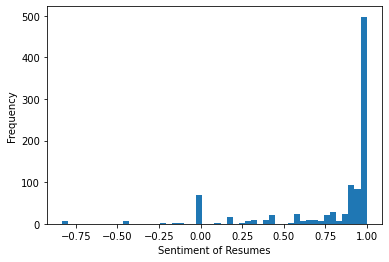

In [129]:
df_resume['VADER score'].plot(bins=50,kind='hist')
plt.xlabel('Sentiment of Resumes')

As we can see there are mostly very positive resumes, however there are some that are more balanced and even a few with negative score.

Let us take a look at the most negative Resume. As we can see it is not that negative, it just about a job that is connected with fire / fighting / nuclear which are rather negative without context. That is why sentiment analysis should be used with more context for such topics as resumes

In [131]:
min_sentiment = df_resume[df_resume["VADER score"] == df_resume["VADER score"].min()]
min_sentiment = min_sentiment.reset_index()
min_sentiment['Resume_str'][0]

'education details electrical engineering skill details microsft office and excell power point exprience monthscompany details company indian navy description academia  matric  diploma in electrical engineering  nuclear biological chemical defence and damage control including fire fighting  leadership certificate course weeks  management certificate course weeks  advance fire fighting including industrial safety weeks'

Last but not least let us check which Category of jobs have the most poitive resumes on average

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

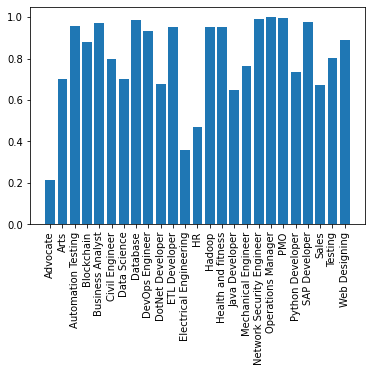

In [132]:
df_mean2 = df_resume.groupby("Category")["VADER score"].mean()
plt.bar(df_mean2.index, df_mean2.values)
plt.xticks(rotation=90)

Most probably advocates and electrical engineers may use some rather negative words such as with previous example, that is why those groups may be such low on average. It is rather hard to explain why other groups differ but some of them are quite counterintuitive. For HR resumes I would expect highly positive words as it is rather 'people' job.

### Conculsions
We acheived our goals that we set at the beggining. We were able to predict job offer category (IT / Non-IT) and the resume candidate profile quite well. The recommendation system based on cosine similarity did quite well and we may say that for simple usage it would fit fine. Based on the analysis we may see that it is posible and wortk to analyse text as it may have real use cases that may save time and money. Moreover we have tried sentiment analysis that can be somehow also useful to track if our Resume is well balanced and not too 'colourful'.